In [248]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc

In [249]:
S_nt_idx = lambda x: 17 * x
S_wt_idx = lambda x: 17 * x + 1
S_tp_idx = lambda x: 17 * x + 2
S_tn_idx = lambda x: 17 * x + 3
V_nt_idx = lambda x: 17 * x + 4
V_wt_idx = lambda x: 17 * x + 5
V_tp_idx = lambda x: 17 * x + 6
V_tn_idx = lambda x: 17 * x + 7
I_nt_idx = lambda x: 17 * x + 8
I_wt_idx = lambda x: 17 * x + 9
I_tn_idx = lambda x: 17 * x + 10
Q_idx = lambda x: 17 * x + 11
R_nt_idx = lambda x: 17 * x + 12 
R_wt_idx = lambda x: 17 * x + 13
R_tp_idx = lambda x: 17 * x + 14
R_tn_idx = lambda x: 17 * x + 15
D_idx = lambda x: 17 * x + 16

In [250]:
def compute_group_metrics(V, num_groups):
    """
    Inputs: V (the initial population for every compartment), num_groups (the number of subpopulations)
    
    This function computes the total susceptible, vaccinated, infected, and recovered individuals in each subpopulation

    Returns: N_list (list of the total population of each subgroup), S_effective, V_effective, I_active, R_total (list of the total susceptible, 
    vaccinated, infected, and recovered populations for each subgroup repectively)
    """
    N_list = []
    S_effective = []
    V_effective = []
    I_active = []
    R_total = []

    for i in range(num_groups): 
        s_eff = V[S_nt_idx(i)] + V[S_wt_idx(i)] + V[S_tp_idx(i)] + V[S_tn_idx(i)]
        v_eff = V[V_nt_idx(i)] + V[V_wt_idx(i)] + V[V_tp_idx(i)] + V[V_tn_idx(i)]
        i_act = V[I_nt_idx(i)] + V[I_wt_idx(i)] + V[I_tn_idx(i)]
        r_tot = V[R_nt_idx(i)] + V[R_wt_idx(i)] + V[R_tn_idx(i)] + V[R_tp_idx(i)]
        q_val = V[Q_idx(i)]

        S_effective.append(s_eff)
        V_effective.append(v_eff)
        I_active.append(i_act)
        R_total.append(r_tot)

        N_list.append(s_eff + v_eff + i_act + q_val + r_tot)

    return N_list, S_effective, V_effective, I_active, R_total

In [251]:
def diff_eqs(input, t, parameters, num_groups): 
    """
    Inputs: input (the intial values for each compartment), parameters (parameters of the system), num_groups (the number of subpopulations)

    This function defines the system of differential equations

    Returns: Y (list of differential equations) 
    """
    beta_matrix = parameters['beta']
    epsilon_matrix = parameters['epsilon']
    gamma_array = parameters['gamma']
    chi_array = parameters['chi']
    nu = parameters['nu']
    mu_array = parameters['mu']
    tau_array = parameters['tau']
    rho = parameters['rho']
    fnr = parameters['fnr']
    fpr = parameters['fpr']
    alpha = parameters['alpha']

    V = input
    Y = np.zeros(num_groups * 17)
    N, S_effective_all, V_effective_all, I_active_all, R_total_all = compute_group_metrics(V, num_groups)

    for i in range(num_groups):
         
        S_eff_i = max(S_effective_all[i], 1e-8)
        V_eff_i = max(V_effective_all[i], 1e-8)
        I_act_i = max(I_active_all[i], 1e-8)
        R_tot_i = max(R_total_all[i], 1e-8)

        susceptible_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * beta_matrix[i, j] / N[j] for j in range(num_groups))
        vaccinated_infec = sum((I_active_all[j] + nu * V[Q_idx(j)]) * epsilon_matrix[i, j] / N[j] for j in range(num_groups))

        Snt, Swt, Stp, Stn = S_nt_idx(i), S_wt_idx(i), S_tp_idx(i), S_tn_idx(i)
        Vnt, Vwt, Vtp, Vtn = V_nt_idx(i), V_wt_idx(i), V_tp_idx(i), V_tn_idx(i)
        Int, Iwt, Itn = I_nt_idx(i), I_wt_idx(i), I_tn_idx(i)
        Q = Q_idx(i)
        Rnt, Rwt, Rtp, Rtn = R_nt_idx(i), R_wt_idx(i), R_tp_idx(i), R_tn_idx(i)
        D = D_idx(i)

        # Susceptible
        Y[Snt] = -susceptible_infec * V[Snt] - chi_array[i] * V[Snt] / S_eff_i - tau_array[i] * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Stp] + V[Stn])
        Y[Swt] = -susceptible_infec * V[Swt] - chi_array[i] * V[Swt] / S_eff_i + tau_array[i] * V[Snt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Swt]
        Y[Stp] = -susceptible_infec * V[Stp] - chi_array[i] * V[Stp] / S_eff_i + rho * fpr * V[Swt] - alpha * V[Stp]
        Y[Stn] = -susceptible_infec * V[Stn] - chi_array[i] * V[Stn] / S_eff_i + rho * (1 - fpr) * V[Swt] - alpha * V[Stn]

        # Vaccinated
        Y[Vnt] = -vaccinated_infec * V[Vnt] + chi_array[i] * (V[Snt] / S_eff_i) + chi_array[i] * (V[Swt] / S_eff_i) + chi_array[i] * (V[Stn] / S_eff_i) + chi_array[i] * (V[Stp] / S_eff_i) - tau_array[i] * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Vtp] + V[Vtn])
        Y[Vwt] = -vaccinated_infec * V[Vwt] + tau_array[i] * V[Vnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Vwt]
        Y[Vtp] = -vaccinated_infec * V[Vtp] + rho * fpr * V[Vwt] - alpha * V[Vtp]
        Y[Vtn] = -vaccinated_infec * V[Vtn] + rho * (1 - fpr) * V[Vwt] - alpha * V[Vtn]

        # Infected
        Y[Int] = susceptible_infec * S_eff_i + vaccinated_infec * V_eff_i - gamma_array[i] * V[Int] - mu_array[i] * V[Int] - tau_array[i] * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Itn])
        Y[Iwt] = tau_array[i] * V[Int] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Iwt] - gamma_array[i] * V[Iwt] - mu_array[i] * V[Iwt]
        Y[Itn] = rho * fnr * V[Iwt] - gamma_array[i] * V[Itn] - mu_array[i] * V[Itn] - alpha * V[Itn]

        # Quarantined
        Y[Q] = rho * (1 - fnr) * V[Iwt] - gamma_array[i] * V[Q] - mu_array[i] * V[Q] 

        # Recovered
        Y[Rnt] = gamma_array[i] * V[Int] + gamma_array[i] * V[Iwt] + gamma_array[i] * V[Itn] + gamma_array[i] * V[Q] - tau_array[i] * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) + alpha * (V[Rtp] + V[Rtn])
        Y[Rwt] = tau_array[i] * V[Rnt] / (S_eff_i + V_eff_i + I_act_i + R_tot_i) - rho * V[Rwt]
        Y[Rtp] = rho * fpr * V[Rwt] - alpha * V[Rtp]
        Y[Rtn] = rho * (1 - fpr) * V[Rwt] - alpha * V[Rtn]

        # Dead
        Y[D] = mu_array[i] * I_act_i + mu_array[i] * V[Q]


    return Y

In [252]:
def generate_allocations(total_resources, step=500): 
    """
    This functions generates a list of all the possible allocation combinations by iterating through all of the possibilities, taking a step of size
    step each iteration. 

    Inputs: the nunber of vaccines that are being distributed each day 

    Outputs: a list of all the possible combinations of how the vaccines can be allocated 
    """
    allocations = []
    steps = total_resources // step
    for i in range(steps + 1):
        for j in range(steps + 1):
            if i + j == steps:
                allocations.append([i * step, j * step])

    return allocations

In [253]:
#This defines the starting conditions for the system. This is what I modify when I am varying the disparity levels
starting_infections = [0.01, 0.01] 
starting_vaccinations = [0.7, 0.7]
num_groups = len(starting_infections)
group_populations = [10**6, 10**6]
total_resources = 20000

INPUT_0 = []
for i in range(num_groups): 
    inf = starting_infections[i]
    vac = starting_vaccinations[i]
    sus = 1 - inf - vac
    pop = group_populations[i]

    group_state = [0] * 17 
    group_state[0] = sus 
    group_state[4] = vac
    group_state[8] = inf
    group_state_scaled = [val * pop for val in group_state]

    INPUT_0.extend(group_state_scaled)
INPUT_0 = np.array(INPUT_0)

R0 = 16
beta = R0*(0.0714)
epsilon = beta * 0.1
allocations = generate_allocations(total_resources)

base_params = {
    'nu': 0.02,
    'tau': [0, 0],
    'rho': 24,
    'fnr': 0.01,
    'fpr': 0.05,
    'alpha': 0.0714,
    'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1 - 0.0653)],
    'mu': [0.0714 * 0.0653, 0.0714 * 0.0653],
}

scenario_num = 0
scenario_list = [{ #This scenario is used to calibrate the parameters using Latin Hypercube Sampling
        'chi': [0, 0],
        'nu': 0.02,
        'tau': [0, 0],
        'rho': 24,
        'fnr': 0.01,
        'fpr': 0.05,
        'alpha': 0.0714,
        'gamma': [0.0714 * (1 - 0.0653), 0.0714 * (1- 0.0653)],
        'mu': [0.0714 * 0.0653, 0.0714 * 0.0653]
    }]
for resource in allocations:
    scenario = base_params.copy() 
    scenario['chi'] = resource
    scenario_list.append(scenario)

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [254]:
#This defines the min-max bounds of the parameters that are calibrated. I am only calibrating the beta values 
param_bounds = {}

for i in range(num_groups):
    for j in range(i, num_groups):
        param_bounds[f'beta_{i}{j}'] = (0.01, 0.5 * beta)           
param_names = list(param_bounds.keys())

In [255]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [256]:
def unpack_sample(sample, num_groups, epsilon_scale=0.1):
    """
    Converts a 1D sample vector (e.g., from LHS) into a dictionary of symmetric beta_ij and derived epsilon_ij parameters.

    Returns:
        param_dict: { 'beta_ij': val, 'epsilon_ij': val, ... }
    """
    param_dict = {}
    idx = 0

    for i in range(num_groups):
        for j in range(i, num_groups):
            beta_val = sample[idx]
            epsilon_val = epsilon_scale * beta_val

            # Fill both beta_ij and beta_ji
            param_dict[f'beta_{i}{j}'] = beta_val
            param_dict[f'beta_{j}{i}'] = beta_val

            # Fill both epsilon_ij and epsilon_ji
            param_dict[f'epsilon_{i}{j}'] = epsilon_val
            param_dict[f'epsilon_{j}{i}'] = epsilon_val

            idx += 1

    return param_dict

In [257]:
def enforce_within_group_dominance(matrix, margin): 
    """
    Inputs: matrix (beta or epsilon), margin to add to the diagonal entries
    
    This function ensures that the within-group transmission rate is higher that the between-group transmission rate by adding a margin to each 
    diagonal entry of the beta and epsilon transmission matrices
    """
    matrix = matrix.copy()
    num_groups = matrix.shape[0]
    max_off_diag = np.max(matrix[~np.eye(num_groups, dtype=bool)])
    for i in range(num_groups):
        matrix[i, i] = max(max_off_diag + margin, matrix[i, i])

    return matrix

In [258]:
def extract_model_outputs(RES_init, num_groups):
    """
    Inputs: RES_init (the solutions to the system of differential equations), num_groups (the number of subpopulations that we are modelling)

    This function returns the model predictions of infected, vaccinated, and dead individuals

    Returns: The model prediction for the number of infected, vaccinated, and dead individuals
    """
    num_timesteps = RES_init.shape[0]
    
    I_model = np.zeros((num_groups, num_timesteps))
    V_model = np.zeros((num_groups, num_timesteps))
    D_model = np.zeros((num_groups, num_timesteps))

    for i in range(num_groups):
        I_model[i, :] = (RES_init[:, I_nt_idx(i)] +
                         RES_init[:, I_wt_idx(i)] +
                         RES_init[:, I_tn_idx(i)])
        
        V_model[i, :] = (RES_init[:, V_nt_idx(i)] +
                         RES_init[:, V_wt_idx(i)] +
                         RES_init[:, V_tp_idx(i)] +
                         RES_init[:, V_tn_idx(i)])
        
        D_model[i, :] = RES_init[:, D_idx(i)]

    return I_model, V_model, D_model

In [259]:
def simulate_model(params, num_groups, scenario_list, scenario_num):
    """
    Inputs: params (the sampled parameter values), num_groups (the number of subgroups)

    This function simulates the disease spread system in order to calibrate the best set of parameters

    Returns: I_model, V_model, D_model (the model's predictions for the number of individuals in the respective compartments using the sampled parameters)
    """
    scenarios = scenario_list[scenario_num]
    param_dict = unpack_sample(params, num_groups, epsilon_scale=0.1)

    beta_matrix = np.zeros((num_groups, num_groups))
    epsilon_matrix = np.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(num_groups):
            beta_matrix[i, j] = param_dict[f'beta_{i}{j}']
            epsilon_matrix[i, j] = param_dict[f'epsilon_{i}{j}']

    all_params = {
    'beta': beta_matrix,
    'epsilon': epsilon_matrix,
    'chi': scenarios['chi'],
    'nu': scenarios['nu'],
    'tau': scenarios['tau'],
    'rho': scenarios['rho'],
    'fnr': scenarios['fnr'],
    'fpr': scenarios['fpr'],
    'alpha': scenarios['alpha'],
    'gamma': scenarios['gamma'],
    'mu': scenarios['mu']
    }

    RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))
    I_model, V_model, D_model = extract_model_outputs(RES_init, num_groups)
    return I_model, V_model, D_model

In [260]:
def MSE_func(params, I_data, V_data, D_data, num_groups, scenario_list, scenario_num): 
    """
    Inputs: params (the sampled parameters), I_data, V_data, D_data (the actual number of individuals in the respective compartments to compare the 
    model output to), num_groups (the number of subgroups)

    This functions computes the difference between the model prediction for susceptible, infected, and dead individuals and the actual data for the 
    respective compartments. The set of parameters that result in the lowest error will be chosen as the ideal set of parameters 

    Returns: the error
    """
    param_dict = unpack_sample(params, num_groups, epsilon_scale=0.1)

    beta_matrix = np.zeros((num_groups, num_groups))
    epsilon_matrix = np.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(num_groups):
            beta_matrix[i, j] = param_dict[f'beta_{i}{j}']
            epsilon_matrix[i, j] = param_dict[f'epsilon_{i}{j}']

    beta_matrix = enforce_within_group_dominance(beta_matrix, margin=0.57)
    epsilon_matrix = enforce_within_group_dominance(epsilon_matrix, margin=0.057)

    for i in range(num_groups):
        for j in range(num_groups):
            param_dict[f'beta_{i}{j}'] = beta_matrix[i, j]
            param_dict[f'epsilon_{i}{j}'] = epsilon_matrix[i, j]

    enforced_params = [param_dict[name] for name in param_names]
    I_model, V_model, D_model = simulate_model(enforced_params, num_groups, scenario_list, scenario_num)
    T = I_data.shape[1]
    I_model = I_model[:, :T]
    V_model = V_model[:, :T]
    D_model = D_model[:, :T]
    return np.mean((I_model - I_data) ** 2) + np.mean((V_model - V_data) ** 2) + np.mean((D_model - D_data) ** 2)

In [261]:
#Calls the helper functions to simulate the best set of parameters resulting in the lowest error 
I_data = np.zeros((num_groups, ND_end))
V_data = np.zeros((num_groups, ND_end))
D_data = np.zeros((num_groups, ND_end))

for i in range(num_groups):
    I_start = (0.01 / (i + 1)) * 10e6
    I_end = (10000 / (i + 1))
    I_data[i] = np.linspace(I_start, I_end, ND_end) + np.random.normal(0, 10, ND_end)
    
    V_start = (0.001 * (i + 1)) * 10e6
    V_end = (0.002 * (i + 1)) * 10e6
    V_data[i] = np.clip(np.linspace(V_start, V_end, ND_end) + np.random.normal(0, 100, ND_end), 0, None)
    
    D_start = (0.001 * (i + 1))
    D_end = (200 / (i + 1))
    D_data[i] = np.clip(np.linspace(D_start, D_end, ND_end) + np.random.normal(0, 5, ND_end), 0, None)

best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data, V_data, D_data, num_groups, scenario_list, scenario_num)
    if error < lowest_error: 
        lowest_error = error
        param_dict = unpack_sample(sample, num_groups, epsilon_scale=0.1)

        beta_matrix = np.zeros((num_groups, num_groups))
        epsilon_matrix = np.zeros((num_groups, num_groups))
        for i in range(num_groups):
            for j in range(num_groups):
                beta_matrix[i, j] = param_dict[f'beta_{i}{j}']
                epsilon_matrix[i, j] = param_dict[f'epsilon_{i}{j}']

        beta_matrix = enforce_within_group_dominance(beta_matrix, margin=0.57)
        epsilon_matrix = enforce_within_group_dominance(epsilon_matrix, margin=0.057)

        beta_matrix[0, 0] = 1.1424
        beta_matrix[1, 1] = 1.428

        for i in range(num_groups):
            for j in range(num_groups):
                param_dict[f'beta_{i}{j}'] = beta_matrix[i, j]
                param_dict[f'epsilon_{i}{j}'] = epsilon_matrix[i, j]

        best_params = [param_dict[name] for name in param_names]
print("Best parameter set:", dict(zip(param_names, best_params)))

Best parameter set: {'beta_00': 1.1424, 'beta_01': 0.5711126155890658, 'beta_11': 1.428}


In [262]:
def run_model(param_names, best_params, scenarios, num_groups, INPUT_0, t_range_init):
    best_params_dict = dict(zip(param_names, best_params))

    beta = np.zeros((num_groups, num_groups))
    for i in range(num_groups):
        for j in range(i, num_groups):
            beta_val = best_params_dict[f'beta_{i}{j}']
            beta[i, j] = beta_val
            beta[j, i] = beta_val  

    epsilon = 0.1 * beta

    all_params = {
        'beta': beta,
        'epsilon': epsilon,
        'chi': scenarios['chi'],
        'nu': scenarios['nu'],
        'tau': scenarios['tau'],
        'rho': scenarios['rho'],
        'fnr': scenarios['fnr'],
        'fpr': scenarios['fpr'],
        'alpha': scenarios['alpha'],
        'gamma': scenarios['gamma'],
        'mu': scenarios['mu']
    }

    RES_init = spi.odeint(diff_eqs, INPUT_0, t_range_init, args=(all_params, num_groups))
    return RES_init


In [263]:
def compute_deaths(RES_init, num_groups, compartments_per_group=17): 
    deaths = []
    for i in range(num_groups): 
        offset = compartments_per_group * i
        deaths.append(RES_init[-1, offset + 16])
    return deaths

In [264]:
def compute_infections(RES_init, num_groups, compartments_per_group=17): 
    infections = []
    for i in range(num_groups): 
        offset = compartments_per_group * i
        infections.append(RES_init[-1, offset + 8] + RES_init[-1, offset + 9] + RES_init[-1, offset + 10] + RES_init[-1, offset + 11])
    return infections

In [265]:
def compute_disparity_index(values): 
    values = np.array(values)
    n = len(values)
    mean_value = np.mean(values)

    if mean_value == 0:
        return 0 

    diff_sum = np.sum([np.abs(x - y) for x in values for y in values])
    
    gini = diff_sum / (2 * n**2 * mean_value)
    return gini

In [266]:
# I manually change the return lines based on which scenario I am running

def compute_objective_function(RES_init, num_groups, x):
    deaths = compute_deaths(RES_init, num_groups) 
    # infections = compute_infections(RES_init, num_groups)
    death_percent = sum(deaths) / (num_groups * 10 ** 6)
    index = compute_disparity_index(deaths)
    return sum(deaths), deaths
    # return death_percent + x * index, deaths
    worst_deaths = max(deaths)
    return worst_deaths, deaths

In [267]:
def nash_objective(RES_init, num_groups, baseline_deaths): 
    deaths = compute_deaths(RES_init, num_groups)
    improvements = [max(1e-6, b - d) for b, d in zip(baseline_deaths, deaths)]
    log_product = sum(np.log(improvements))
    return -log_product, deaths


 BEST SCENARIO FOUND:
  Scenario Index: 30
  Allocation: [14500, 5500]
  Deaths: [59119.432116763724, 61549.303107215375]
  Objective value: 120668.7352239791
  Disparity index: 0.010068353604359278

 Scenario 31 – Group 1:
  Final Susceptible: 0
  Final Infected: 7,355 (peak: 313,239)
  Final Vaccinated: 87,294
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 846,232
  Final Dead: 59,119
  Total Population: 1,000,000

 Scenario 31 – Group 2:
  Final Susceptible: -0
  Final Infected: 5,484 (peak: 355,690)
  Final Vaccinated: 51,953
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 881,013
  Final Dead: 61,549
  Total Population: 1,000,000

Scenario 31 – TOTAL ACROSS ALL GROUPS:
  Final Susceptible: -0
  Final Infected: 12,840 (peak: 665,058)
  Final Vaccinated: 139,247
  Final Quarantined: 0 (peak: 0)
  Final Recovered: 1,727,245
  Final Dead: 120,669
  Total Population: 2,000,000
  Total Infected 1,860,753


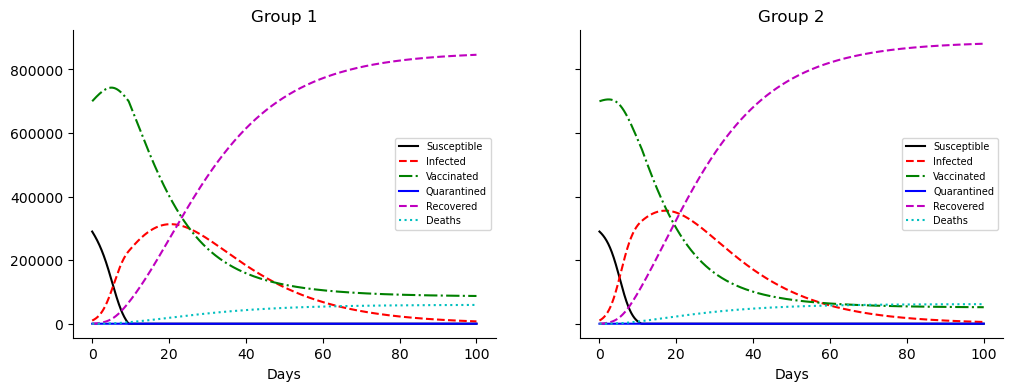

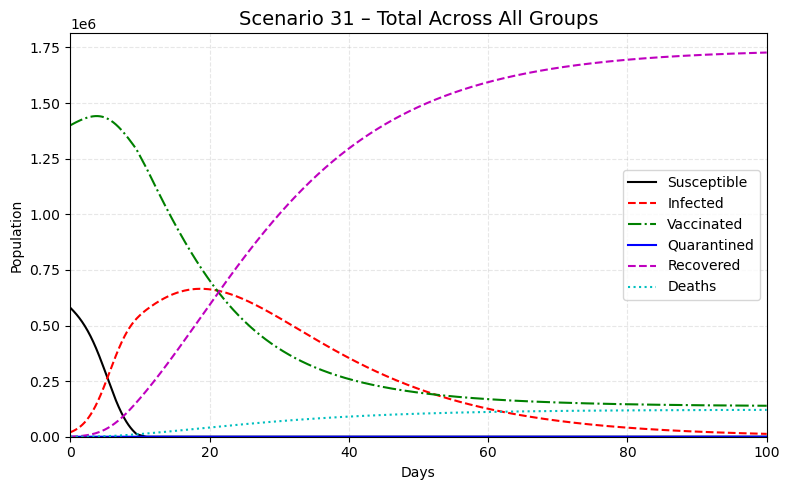

In [268]:
best_result = None
best_score = float('inf')
best_RES = None
for idx, scenario in enumerate(scenario_list[1:], start=1):
    INPUT_0 = []
    for i in range(num_groups): 
        inf = starting_infections[i]
        vac = starting_vaccinations[i]
        sus = 1 - inf - vac
        pop = group_populations[i]

        group_state = [0] * 17 
        group_state[0] = sus 
        group_state[4] = vac
        group_state[8] = inf
        group_state_scaled = [val * pop for val in group_state]

        INPUT_0.extend(group_state_scaled)
    INPUT_0 = np.array(INPUT_0)

    RES_init = run_model(param_names, best_params, scenario, num_groups, INPUT_0, t_range_init)
    # baseline_scenario = base_params.copy()
    # baseline_scenario['chi'] = [0, 0]
    # baseline_RES = run_model(param_names, best_params, baseline_scenario, num_groups, INPUT_0, t_range_init)
    # baseline_deaths = compute_deaths(baseline_RES, num_groups)

    # score, deaths = nash_objective(RES_init, num_groups, baseline_deaths)
    score, deaths = compute_objective_function(RES_init, num_groups, x=0.1) # Change this later
    disparity_index = compute_disparity_index(compute_deaths(RES_init, num_groups))

    if score < best_score and disparity_index < 0.016021878837215756:
        best_score = score
        best_result = {
            'scenario_index': idx,
            'chi': scenario['chi'],
            'objective_value': score,
            'disparity_index': disparity_index,
            'deaths': deaths
        }
        best_RES = RES_init

print("\n BEST SCENARIO FOUND:")
print(f"  Scenario Index: {best_result['scenario_index']}")
print(f"  Allocation: {best_result['chi']}")
print(f"  Deaths: {best_result['deaths']}")
print(f"  Objective value: {best_result['objective_value']}")
print(f"  Disparity index: {best_result['disparity_index']}")

RES_init = best_RES
compartments_per_group = 17  
t_vals = np.arange(0, ND_end + t_inc, t_inc)

fig, axs = plt.subplots(1, num_groups, figsize=(6*num_groups, 4), sharey=True)
if num_groups == 1:
    axs = [axs]  # make iterable

for i in range(num_groups): 
    offset = compartments_per_group * i
    S_total = RES_init[:, offset + 0] + RES_init[:, offset + 1] + RES_init[:, offset + 2] + RES_init[:, offset + 3]
    I_total = RES_init[:, offset + 8] + RES_init[:, offset + 9] + RES_init[:, offset + 10]
    V_total = RES_init[:, offset + 4] + RES_init[:, offset + 5] + RES_init[:, offset + 6] + RES_init[:, offset + 7]
    Q = RES_init[:, offset + 11]
    R = RES_init[:, offset + 12] + RES_init[:, offset + 13] + RES_init[:, offset + 14] + RES_init[:, offset + 15]
    D = RES_init[:, offset + 16]

    print(f"\n Scenario {best_result['scenario_index']+1} – Group {i+1}:")
    print(f"  Final Susceptible: {S_total[-1]:,.0f}")
    print(f"  Final Infected: {I_total[-1]:,.0f} (peak: {np.max(I_total):,.0f})")
    print(f"  Final Vaccinated: {V_total[-1]:,.0f}")
    print(f"  Final Quarantined: {Q[-1]:,.0f} (peak: {np.max(Q):,.0f})")
    print(f"  Final Recovered: {R[-1]:,.0f}")
    print(f"  Final Dead: {D[-1]:,.0f}")
    print(f"  Total Population: {S_total[-1] + I_total[-1] + V_total[-1] + Q[-1] + R[-1] + D[-1]:,.0f}")

    axs[i].plot(t_vals, S_total, '-k', label='Susceptible')
    axs[i].plot(t_vals, I_total, '--r', label='Infected')
    axs[i].plot(t_vals, V_total, '-.g', label='Vaccinated')
    axs[i].plot(t_vals, Q, '-b', label='Quarantined')
    axs[i].plot(t_vals, R, '--m', label='Recovered')
    axs[i].plot(t_vals, D, ':c', label='Deaths')

    axs[i].set_title(f'Group {i+1}')
    axs[i].set_xlabel('Days')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].legend(fontsize=7)

S_total_all = np.zeros_like(t_vals)
I_total_all = np.zeros_like(t_vals)
V_total_all = np.zeros_like(t_vals)
Q_total_all = np.zeros_like(t_vals)
R_total_all = np.zeros_like(t_vals)
D_total_all = np.zeros_like(t_vals)

for i in range(num_groups):
    offset = compartments_per_group * i
    S_total_all += RES_init[:, offset + 0] + RES_init[:, offset + 1] + RES_init[:, offset + 2] + RES_init[:, offset + 3]
    I_total_all += RES_init[:, offset + 8] + RES_init[:, offset + 9] + RES_init[:, offset + 10]
    V_total_all += RES_init[:, offset + 4] + RES_init[:, offset + 5] + RES_init[:, offset + 6] + RES_init[:, offset + 7]
    Q_total_all += RES_init[:, offset + 11]
    R_total_all += RES_init[:, offset + 12] + RES_init[:, offset + 13] + RES_init[:, offset + 14] + RES_init[:, offset + 15]
    D_total_all += RES_init[:, offset + 16]

print(f"\nScenario {best_result['scenario_index']+1} – TOTAL ACROSS ALL GROUPS:")
print(f"  Final Susceptible: {S_total_all[-1]:,.0f}")
print(f"  Final Infected: {I_total_all[-1]:,.0f} (peak: {np.max(I_total_all):,.0f})")
print(f"  Final Vaccinated: {V_total_all[-1]:,.0f}")
print(f"  Final Quarantined: {Q_total_all[-1]:,.0f} (peak: {np.max(Q_total_all):,.0f})")
print(f"  Final Recovered: {R_total_all[-1]:,.0f}")
print(f"  Final Dead: {D_total_all[-1]:,.0f}")
print(f"  Total Population: {S_total_all[-1] + I_total_all[-1] + V_total_all[-1] + Q_total_all[-1] + R_total_all[-1] + D_total_all[-1]:,.0f}")
print(f"  Total Infected {I_total_all[-1] + Q_total_all[-1] + R_total_all[-1] + D_total_all[-1]:,.0f}")

plt.figure(figsize=(8, 5))
plt.plot(t_vals, S_total_all, '-k', label='Susceptible')
plt.plot(t_vals, I_total_all, '--r', label='Infected')
plt.plot(t_vals, V_total_all, '-.g', label='Vaccinated')
plt.plot(t_vals, Q_total_all, '-b', label='Quarantined')
plt.plot(t_vals, R_total_all, '--m', label='Recovered')
plt.plot(t_vals, D_total_all, ':c', label='Deaths')

plt.title(f"Scenario {best_result['scenario_index']+1} – Total Across All Groups", fontsize=14)
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.xlim([0, ND_end])
plt.ylim([0, 1.05 * max(
np.max(S_total_all),
np.max(I_total_all),
np.max(V_total_all),
np.max(Q_total_all),
np.max(R_total_all),
np.max(D_total_all)
)]) 
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()